In [21]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
import optuna

TODO:
- Impute bathrooms DONE
- ceiling DONE
- area_living DONE
- area_kitchen DONE
- balconies and loggias DONE

In [30]:
apartments = pd.read_csv('resources/data/apartments_train.csv')
buildings = pd.read_csv('resources/data/buildings_train.csv')
data = pd.merge(apartments, buildings.set_index('id'), how='left', left_on='building_id', right_index=True)

apartments_test = pd.read_csv('resources/data/apartments_test.csv')
buildings_test = pd.read_csv('resources/data/buildings_test.csv')
data_test = pd.merge(apartments_test, buildings_test.set_index('id'), how='left', left_on='building_id', right_index=True)

In [34]:
data["split"] = 'train'
data_test["split"] = 'test'

In [36]:
all_data = pd.concat([data, data_test])

In [40]:
all_data['bathrooms_total'] = all_data.bathrooms_private + all_data.bathrooms_shared

In [18]:
def rmlse(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all() 
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

## Imputing `district`

In [133]:
# temporary imputation. SHould impute whole dataset together.
no_district = data.district.isna()
districts = data.loc[no_district].apply(
    lambda b: data.loc[
        (data[~no_district][["latitude", "longitude"]] - b[["latitude", "longitude"]]).abs().sum(axis=1).idxmin()
    ].district,
    axis=1
)
districts.rename("district", inplace=True)
data.update(districts)

## Impute `bathrooms_total`

In [48]:
# Do not have en reasonable strategy other than using the mean.
all_data['bathrooms_total'] = all_data['bathrooms_total'].fillna(all_data.bathrooms_total.mean())

## Impute `ceiling`

In [132]:
pd.set_option('display.max_rows', 500)
all_data.drop(columns = ['price', 'split', 'id', 'street', 'address']).apply(lambda x: x.corr(all_data.price)).sort_values()[-5:]

area_kitchen       0.364758
bathrooms_total    0.367073
rooms              0.411317
area_living        0.707580
area_total         0.814829
dtype: float64

In [67]:
mean = data.ceiling.mean()
high_ceil= np.zeros(data.shape[0])
for i in range(data.shape[0]):
    if not pd.isna(data.ceiling[i]) and data.ceiling[i] > mean:
        high_ceil[i] = 1

data['high_ceil'] = high_ceil


In [73]:
pd.set_option('display.max_rows', 500)
data.loc[data.ceiling > mean, ['high_ceil', 'ceiling']]

,high_ceil,ceiling
174,1.0,4.2
405,1.0,3.5
453,1.0,3.3
458,1.0,3.3
467,1.0,3.3
...,...,...
23210,1.0,3.5
23213,1.0,3.8
23256,1.0,3.3
23269,1.0,3.3


<AxesSubplot:xlabel='high_ceil', ylabel='logprice'>

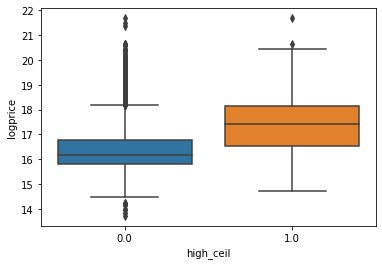

In [76]:
sns.boxplot(x = 'high_ceil', y = 'logprice', data = data)
data.loc[data.high_ceil ==1].count()

## Imputing `new`

In [80]:
isnew = np.zeros(data.shape[0])
for i in range(data.shape[0]):
    if not pd.isna(data.new[i]) and data.new[i] == 1:
        isnew[i] = 1

data['isnew'] = isnew

<AxesSubplot:xlabel='isnew', ylabel='logprice'>

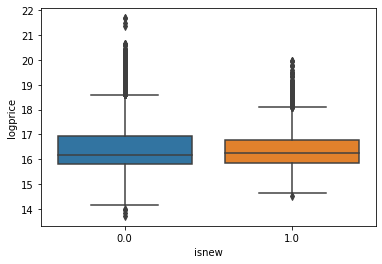

In [81]:
sns.boxplot(x = 'isnew', y = 'logprice', data = data)

In [87]:
new_const = data.loc[data.new == 1, 'constructed']
old_const = data.loc[data.new == 0, 'constructed']


<AxesSubplot:xlabel='constructed', ylabel='Count'>

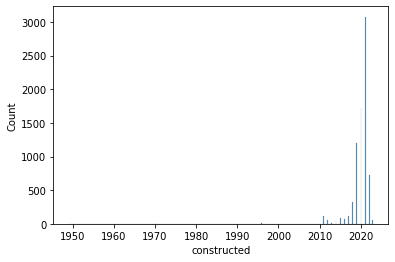

In [85]:
# new feature is bullshit
sns.histplot(new_const)

<AxesSubplot:xlabel='constructed', ylabel='Count'>

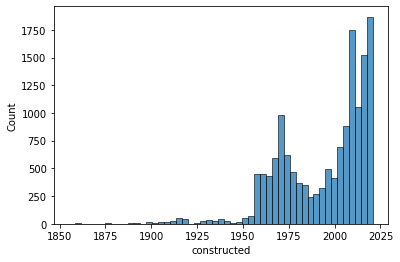

In [88]:
sns.histplot(old_const)

In [105]:
# Rather create new feature based on construction
new2 = np.zeros(data.shape[0])
for i in range(data.shape[0]):
    if not pd.isna(data.new[i]) and data.constructed[i] > 1998:
        new2[i] = 1

data['new2'] = new2

<AxesSubplot:xlabel='new2', ylabel='logprice'>

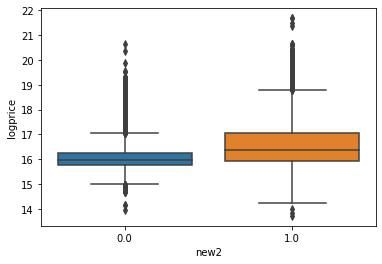

In [106]:
sns.boxplot(data = data, x = 'new2', y = 'logprice')

## Imputing `ballog`

In [109]:
# Seems reasonable to assume that number of loggias/balconies is zero for NAN-values.
data['balconies'] = data['balconies'].fillna(0)
data['loggias'] = data['loggias'].fillna(0)

## Impute `area_living`

In [113]:
all_data.drop(columns = ['price', 'split', 'id', 'street', 'address']).apply(lambda x: x.corr(all_data.area_living)).sort_values()[-3:]

rooms          0.724326
area_total     0.908238
area_living    1.000000
dtype: float64

In [111]:
from sklearn import linear_model
# Impute by regressing on the two most correlated features
missing_idx = data['area_living'].isna()
model = linear_model.LinearRegression()
model.fit(X = data.loc[~missing_idx, ['area_total', 'rooms']], y = data.loc[~missing_idx, 'area_living'])
data.loc[missing_idx, 'area_living'] = model.predict(data.loc[missing_idx, ['area_total', 'rooms']])

missing_idx_test = data_test['area_living'].isna()
data_test.loc[missing_idx_test, 'area_living'] = model.predict(data_test.loc[missing_idx_test, ['area_total', 'rooms']])

## Imputing `area_kitchen`

In [117]:
all_data.drop(columns = ['price', 'split', 'id', 'street', 'address']).apply(lambda x: x.corr(all_data.area_kitchen)).sort_values()[-10:]

new                 0.263295
elevator_service    0.303741
bathrooms_shared    0.312293
rooms               0.316543
constructed         0.380721
seller              0.382460
area_living         0.390412
bathrooms_total     0.499980
area_total          0.525835
area_kitchen        1.000000
dtype: float64

In [121]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=4)
imp = imputer.fit_transform(data[['longitude', 'latitude', 'area_total', 'area_kitchen']])
data['area_kitchen'] = imp[:, -1]

In [123]:
data.price.corr(data.area_kitchen)

0.379042082967607

## Impute `parking`

In [126]:
# Assume that nan-values means no parking
# fill with 3 for now:
data['parking'].fillna(3)

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
23280    0.0
23281    0.0
23282    0.0
23283    0.0
23284    3.0
Name: parking, Length: 23285, dtype: float64

## Imputing `garbage_chute`

<AxesSubplot:xlabel='garbage_chute', ylabel='logprice'>

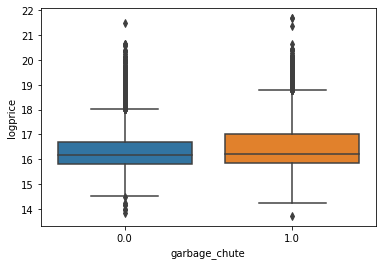

In [128]:

data['garbage_chute'] = data['garbage_chute'].fillna(0)
sns.boxplot(x = 'garbage_chute', y = 'logprice', data = data)

## Impute `heating`

In [129]:
# introduce new category for missing values
data['heating'] = data['heating'].fillna(4)

## Imputing `material`

In [130]:
# introduce new category for missing values
data['material'] = data['material'].fillna(6)

## Imputing `condition`

In [131]:
# introduce new category for missing values
data['condition'] = data['condition'].fillna(4)

## Creating feature for distance from city center

In [136]:
LAT_CENT = 55.751244
LON_CENT = 37.618423
dist = np.sqrt((data.latitude - LAT_CENT)**2 + (data.longitude - LON_CENT)**2)

-0.23950339560684547

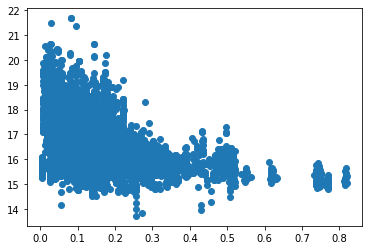

In [140]:
data['center_dist'] = dist
plt.scatter(data.center_dist, data.logprice)
data['price'].corr(data.center_dist)

In [141]:
FEATURES = ["latitude", "longitude", "constructed", "area_total", "area_living", "area_kitchen", "rooms", "district", 
            "material", "condition", "heating", "new2", "parking", "garbage_chute", "ballog", "bathrooms_total", "high_ceil", 'center_dist']

NUMERIC = ["latitude", "longitude", "constructed", "area_total", "area_living", "area_kitchen", "rooms", "center_dist", "ballog", "bathrooms_total"]
CAT = [ "district", "material", "condition", "heating", "new2", "parking", "garbage_chute"]


X_train = data[FEATURES].copy()

KeyError: "['ballog', 'bathrooms_total'] not in index"

In [ ]:
# transforming skewed features
from scipy.stats import skew

y = np.log(data.price)

#log transform skewed numeric features:

skewed_feats = X_train[NUMERIC].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
print(skewed_feats)

X_train[skewed_feats] = np.log1p(X_train[skewed_feats])

In [ ]:
X_train = pd.get_dummies(X_train, columns=CAT)

In [ ]:
from sklearn.linear_model import  LassoCV 
from sklearn.model_selection import cross_val_score

def rmlse_cv(model):
    rmlse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_log_error", cv = 5))
    return(rmlse)

In [ ]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)
rmlse_cv(model_lasso).mean()

# Imputing categorical variables

In [25]:
FEATURES = ["latitude", "longitude", "constructed", "area_total", "rooms", "seller", "district", "material", "condition", "heating", "new", 
                "layout", "parking", "garbage_chute"]

CATEGORICAL_FEATURES = ["seller", "district", "material", "condition", "heating", "new", 
                "layout",  "parking", "garbage_chute"]

In [26]:
data[CATEGORICAL_FEATURES] = data[CATEGORICAL_FEATURES].fillna(-1)
data[CATEGORICAL_FEATURES] = data[CATEGORICAL_FEATURES].astype('int')

In [29]:
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 1, 1000),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
        "depth": trial.suggest_int("depth", 6, 14),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.001, 100.0),
        "random_strength": trial.suggest_int("random_strength", 0, 100),
        "bagging_temperature": trial.suggest_loguniform("bagging_temperature", 0.001, 100.0),
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    model = CatBoostRegressor(objective="RMSE", random_seed=42, silent=True, thread_count=1, **params)

    scores = []
    for train_idx, test_idx in kf.split(data[FEATURES], data.price):
        train, test = data.iloc[train_idx], data.iloc[test_idx]

        model.fit(train[FEATURES], np.log(train.price / train.area_total))

        predictions = np.exp(model.predict(test[FEATURES])) * test.area_total
        scores.append(rmlse(test.price, predictions))

    return np.mean(scores)

In [31]:
study = optuna.create_study(
    sampler=optuna.samplers.TPESampler(seed=42),
    study_name="CatBoost",
    direction="minimize",
    load_if_exists=True
)
study.optimize(objective, n_trials = 10)

[I 2021-11-08 13:10:35,205] A new study created in memory with name: CatBoost
Custom logger is already specified. Specify more than one logger at same time is not thread safe.[I 2021-11-08 13:13:31,269] Trial 0 finished with value: 0.15330353416582296 and parameters: {'iterations': 375, 'learning_rate': 0.36808608148776095, 'depth': 12, 'l2_leaf_reg': 0.9846738873614566, 'random_strength': 15, 'bagging_temperature': 0.0060252157362038605}. Best is trial 0 with value: 0.15330353416582296.
[I 2021-11-08 13:13:46,325] Trial 1 finished with value: 0.16761688339460185 and parameters: {'iterations': 59, 'learning_rate': 0.21766241123453672, 'depth': 11, 'l2_leaf_reg': 3.4702669886504163, 'random_strength': 2, 'bagging_temperature': 70.72114131472235}. Best is trial 0 with value: 0.15330353416582296.
[I 2021-11-08 13:14:10,400] Trial 2 finished with value: 0.2696699432738231 and parameters: {'iterations': 833, 'learning_rate': 0.003741940611118496, 'depth': 7, 'l2_leaf_reg': 0.008260808399079

KeyboardInterrupt: 